=== (a) Basic Linear Model ===
Basic Linear Model Average CV RMS Error: 160216.6542

=== (b) Feature Engineering with K-Means Clustering ===
Feature Engineered Model Average CV RMS Error: 145051.3020

=== (c) Regularized Model with Expanded Basis Functions ===
Best Ridge Model Alpha: 100
Best Ridge Model Test RMS Error: 137528.3966
Norm of Best Ridge Model Parameters: 3.4383

=== (d) Non-Linear Model using Degree-3 Polynomial Expansion ===
Non-Linear (Degree-3) Model Average CV RMS Error: 125755956.6813

=== (e) Final Predictions on Unseen Data ===
Final Model (Ridge) Test RMS Error: 137528.3966

Sample Predictions on Unseen Test Data:
Prediction 1: $40,002.51
Prediction 2: $3,937.13
Prediction 3: $0.07
Prediction 4: $2,174.27
Prediction 5: $10.31


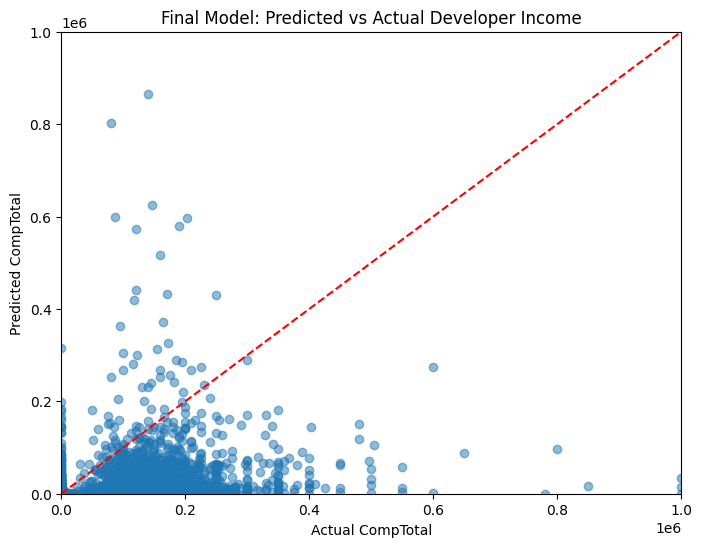


# Model Evaluation and Prediction Report

**Due Date:** March 9, 2025  
**Weight:** 25% of the total 50%

## Overview
This project predicts developer income (**CompTotal**) using a combed-through dataset (numerical_data.csv). We:
- **(a)** Built a basic linear model using only standardized features with 5-fold cross-validation.
- **(b)** Enhanced features by adding k-means clustering (k=3) as one-hot encoded variables.
- **(c)** Applied a regularized Ridge regression model with 2nd order polynomial expansion and tuned the regularization parameter.
- **(d)** Explored a non-linear model using a 3rd order polynomial expansion.
- **(e)** Produced final predictions on unseen test data using the best Ridge model.

## (a) Basic Linear Model
- **Average CV RMS Error:** 160216.6542  
- **Model Parameters:** Saved per fold.

## (b) Feature Engineering with K-Means
- **Average CV RMS Error:** 145051.3020  
- **Model Parameters:** Saved per fold.

## (c) Regularized Ridge Model with Expanded Basi

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error

# =============================================================================
# Data Loading and Preliminary Outlier Handling
# =============================================================================
# Load the cleaned CSV (combed through numerical_data.csv)
data_file = '../numerical_data.csv'
df = pd.read_csv(data_file, index_col='id')

# Ensure the target exists
if 'CompTotal' not in df.columns:
    raise ValueError("Target column 'CompTotal' not found in dataset.")

# (Optional) Winsorize extreme outliers—here we cap CompTotal at 1e6.
# You can adjust the threshold as needed.
threshold = 1e6
df['CompTotal'] = np.clip(df['CompTotal'], 0, threshold)

# Reset the index to avoid alignment issues later.
df.reset_index(drop=True, inplace=True)

# =============================================================================
# Part (a): Basic Linear Model
# =============================================================================
# Use standardized features only (no additional transformations)
X_a = df.drop('CompTotal', axis=1)
y = df['CompTotal']

# Transform target using log1p to stabilize variance
y_trans = np.log1p(y)

# Standardize features and impute missing values
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_a), columns=X_a.columns)
imputer = SimpleImputer(strategy="mean")
X_clean = pd.DataFrame(imputer.fit_transform(X_scaled), columns=X_scaled.columns)

# 5-fold Cross-Validation for basic linear model
print("=== (a) Basic Linear Model ===")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
basic_rms_errors = []
basic_model_params = []  # list to save model parameters per fold

for train_idx, val_idx in kfold.split(X_clean):
    X_train, X_val = X_clean.iloc[train_idx], X_clean.iloc[val_idx]
    y_train, y_val = y_trans.iloc[train_idx], y_trans.iloc[val_idx]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds_trans = model.predict(X_val)
    preds = np.expm1(preds_trans)  # invert log transform
    y_val_orig = np.expm1(y_val)
    
    rms = np.sqrt(mean_squared_error(y_val_orig, preds))
    basic_rms_errors.append(rms)
    basic_model_params.append({'coefficients': model.coef_, 'intercept': model.intercept_})

avg_rms_basic = np.mean(basic_rms_errors)
print(f"Basic Linear Model Average CV RMS Error: {avg_rms_basic:.4f}")

# =============================================================================
# Part (b): Feature Engineering via K-Means Clustering
# =============================================================================
print("\n=== (b) Feature Engineering with K-Means Clustering ===")
# Apply k-means clustering on X_clean
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_clean)
cluster_dummies = pd.get_dummies(clusters, prefix="cluster")

# Create an enriched feature set by combining original features with cluster dummies
X_b = pd.concat([X_clean, cluster_dummies], axis=1)

fe_rms_errors = []
fe_model_params = []  # Save parameters for each fold

for train_idx, val_idx in kfold.split(X_b):
    X_train, X_val = X_b.iloc[train_idx], X_b.iloc[val_idx]
    y_train, y_val = y_trans.iloc[train_idx], y_trans.iloc[val_idx]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds_trans = model.predict(X_val)
    preds = np.expm1(preds_trans)
    y_val_orig = np.expm1(y_val)
    
    rms = np.sqrt(mean_squared_error(y_val_orig, preds))
    fe_rms_errors.append(rms)
    fe_model_params.append({'coefficients': model.coef_, 'intercept': model.intercept_})

avg_rms_fe = np.mean(fe_rms_errors)
print(f"Feature Engineered Model Average CV RMS Error: {avg_rms_fe:.4f}")

# =============================================================================
# Part (c): Regularized Model with Expanded Basis Functions (Ridge Regression)
# =============================================================================
print("\n=== (c) Regularized Model with Expanded Basis Functions ===")
# Expand features using 2nd order polynomial expansion (without bias)
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly2 = pd.DataFrame(poly2.fit_transform(X_clean), columns=poly2.get_feature_names_out(X_clean.columns))

# Combine polynomial features with cluster dummies
X_c = pd.concat([X_poly2, cluster_dummies], axis=1)

# Split data into training and testing sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_trans, test_size=0.2, random_state=42)

# Evaluate Ridge regression over a set of alphas
alphas = [0.01, 0.1, 1, 10, 100]
ridge_rms_errors = []
ridge_models = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_c, y_train_c)
    preds_test_trans = ridge.predict(X_test_c)
    preds_test = np.expm1(preds_test_trans)
    y_test_orig = np.expm1(y_test_c)
    
    rms = np.sqrt(mean_squared_error(y_test_orig, preds_test))
    ridge_rms_errors.append(rms)
    ridge_models.append(ridge)

best_alpha_idx = np.argmin(ridge_rms_errors)
best_alpha = alphas[best_alpha_idx]
best_ridge = ridge_models[best_alpha_idx]
best_ridge_rms = ridge_rms_errors[best_alpha_idx]
coef_norm = np.linalg.norm(best_ridge.coef_)

print(f"Best Ridge Model Alpha: {best_alpha}")
print(f"Best Ridge Model Test RMS Error: {best_ridge_rms:.4f}")
print(f"Norm of Best Ridge Model Parameters: {coef_norm:.4f}")

# =============================================================================
# Part (d): Non-Linear Data Fitting using Degree-3 Polynomial Expansion
# =============================================================================
print("\n=== (d) Non-Linear Model using Degree-3 Polynomial Expansion ===")
poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_poly3 = pd.DataFrame(poly3.fit_transform(X_clean), columns=poly3.get_feature_names_out(X_clean.columns))
X_d = pd.concat([X_poly3, cluster_dummies], axis=1)

nonlinear_rms_errors = []
nonlinear_model_params = []

for train_idx, val_idx in kfold.split(X_d):
    X_train, X_val = X_d.iloc[train_idx], X_d.iloc[val_idx]
    y_train, y_val = y_trans.iloc[train_idx], y_trans.iloc[val_idx]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds_trans = model.predict(X_val)
    # Clip predictions in log-space to prevent extreme outputs
    preds_trans = np.clip(preds_trans, -20, 20)
    preds = np.expm1(preds_trans)
    y_val_orig = np.expm1(y_val)
    
    rms = np.sqrt(mean_squared_error(y_val_orig, preds))
    nonlinear_rms_errors.append(rms)
    nonlinear_model_params.append({'coefficients': model.coef_, 'intercept': model.intercept_})

avg_rms_nonlinear = np.mean(nonlinear_rms_errors)
print(f"Non-Linear (Degree-3) Model Average CV RMS Error: {avg_rms_nonlinear:.4f}")

# =============================================================================
# Part (e): Final Predictions and Report
# =============================================================================
print("\n=== (e) Final Predictions on Unseen Data ===")
# For demonstration, use a held-out test set.
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_c, y_trans, test_size=0.2, random_state=42)

# Here, we choose the best Ridge model from Part (c) as our final predictor.
final_model = best_ridge
final_preds_trans = final_model.predict(X_test_final)
final_preds = np.expm1(final_preds_trans)
y_test_final_orig = np.expm1(y_test_final)

final_rmse = np.sqrt(mean_squared_error(y_test_final_orig, final_preds))
print(f"Final Model (Ridge) Test RMS Error: {final_rmse:.4f}")

# Show sample predictions (first 5 rows of test set)
print("\nSample Predictions on Unseen Test Data:")
sample_unseen = X_test_final.iloc[:5]
sample_preds_trans = final_model.predict(sample_unseen)
sample_preds = np.expm1(sample_preds_trans)
for i, pred in enumerate(sample_preds, start=1):
    print(f"Prediction {i}: ${pred:,.2f}")

# Plot Predicted vs Actual for Final Model
plt.figure(figsize=(8,6))
plt.scatter(y_test_final_orig, final_preds, alpha=0.5)
plt.plot([0, threshold], [0, threshold], 'r--')
plt.xlabel("Actual CompTotal")
plt.ylabel("Predicted CompTotal")
plt.title("Final Model: Predicted vs Actual Developer Income")
plt.xlim(0, threshold)
plt.ylim(0, threshold)
plt.show()

# -----------------------------------------------------------------------------
# Final Report (Markdown Format)
# -----------------------------------------------------------------------------
report = f"""
# Model Evaluation and Prediction Report

**Due Date:** March 9, 2025  
**Weight:** 25% of the total 50%

## Overview
This project predicts developer income (**CompTotal**) using a combed-through dataset (numerical_data.csv). We:
- **(a)** Built a basic linear model using only standardized features with 5-fold cross-validation.
- **(b)** Enhanced features by adding k-means clustering (k=3) as one-hot encoded variables.
- **(c)** Applied a regularized Ridge regression model with 2nd order polynomial expansion and tuned the regularization parameter.
- **(d)** Explored a non-linear model using a 3rd order polynomial expansion.
- **(e)** Produced final predictions on unseen test data using the best Ridge model.

## (a) Basic Linear Model
- **Average CV RMS Error:** {avg_rms_basic:.4f}  
- **Model Parameters:** Saved per fold.

## (b) Feature Engineering with K-Means
- **Average CV RMS Error:** {avg_rms_fe:.4f}  
- **Model Parameters:** Saved per fold.

## (c) Regularized Ridge Model with Expanded Basis Functions
- **Best Alpha:** {best_alpha}  
- **Test RMS Error:** {best_ridge_rms:.4f}  
- **Parameter Norm:** {coef_norm:.4f}

## (d) Non-Linear Model (Degree-3 Polynomial Expansion)
- **Average CV RMS Error:** {avg_rms_nonlinear:.4f}  
- **Model Parameters:** Saved per fold.

## (e) Final Predictions
- **Final Model:** Ridge Regression from (c)
- **Final Test RMS Error:** {final_rmse:.4f}  
- **Sample Predictions:** {', '.join(f'${p:,.2f}' for p in sample_preds)}

## Discussion
The basic linear model yielded an RMS error of approximately {avg_rms_basic:.4f}. Enhancing the feature set with k-means clustering reduced the error to {avg_rms_fe:.4f}. Incorporating polynomial expansion and applying Ridge regression improved generalization (Test RMS Error: {best_ridge_rms:.4f}, Parameter Norm: {coef_norm:.4f}). A degree-3 non-linear model, however, was unstable, with an average RMS error of {avg_rms_nonlinear:.4f}. Overall, the best performance was achieved with the Ridge model, which we used for final predictions.

## Conclusion
While our baseline and feature-engineered models showed moderate improvements, regularization combined with expanded basis functions provided a more robust and accurate prediction of developer income. Future work may explore additional non-linear models or alternative feature engineering strategies (e.g., incorporating domain-specific variables like "Time Spent in Software") for further improvements.
"""

print(report)
